#Імпорт та обробка даних

In [45]:
import numpy as np
import pandas as pd
from operator import attrgetter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns


from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/files_mate
df = pd.read_csv("Data_Analyst_Test_Task_3.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/files_mate


,install_date,country_code,media_source,spend_usd,subscribers,erevenue_12month_usd,country,region,subregion,channel type,case_type
0,2020-12-28,AD,ms_1,"0,070004",0,0,Andorra,Europe,Southern Europe,Paid,Paid with no subs
1,2020-12-28,AE,ms_1,"33,681845",1,"27,993",UAE,Asia,Western Asia,Paid,Paid with subs
2,2020-12-28,AE,ms_2,"10,449999",1,"6,747059784",UAE,Asia,Western Asia,Paid,Paid with subs
3,2020-12-28,AF,ms_1,"1,4601",0,0,Afghanistan,Asia,Southern Asia,Paid,Paid with no subs
4,2020-12-28,AG,ms_1,"0,19001",0,0,Antigua & Barbuda,Americas,Caribbean,Paid,Paid with no subs


До нашої таблиці я додала такі стовпці: повна назва країни, регіон, субрегіон. Щодо стовпця channel type - у датасеті нема поділу на органічний та платний трафік, що ускладнює аналіз та розрахунок деяких метрик, просто таке припущення дозволить виділити додатковий зріз для оцінок відмінності перфомансу "каналів". Стовпець case_type створений суто для зручності, щоб при розрахунках та побудовах графіків/агрегацій не доводилось використовувати багато фільтрувань. Варто зазначити що датасет вже був очищений, без дублікатів, зайвих пробілів. Що було дивним, це рядки, де витрати та підписники є, але прогнозований дохід = 0. Оскільки це вже користувачі з передплатою, це наврядчи особливість прогнозу, але таких рядків 153, тому ми не можемо їх просто вилучити. Заповнити, відповідно, також не вийде, оскільки не знайшла між даними видимої закономірності. Також виявила 9 рядків з від'ємним значенням erevenue_12month_usd. В інформації про датасет не було нічого зазначено про рефанди, чи ще щось, щоб могло пояснювати такі значення, тому спиратись на них небезпечно. Також ці дані розбиті по різним країнам, когортам, медіа сорсам і складають невелику к-сть, тому я прийняла рішення їх вилучити оскільки це не сприятиме сильному спотворенню даних. Всі описані дії вище робила в Google Sheets.

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1755 entries, 0 to 1754
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   install_date          1755 non-null   object
 1   country_code          1748 non-null   object
 2   media_source          1755 non-null   object
 3   spend_usd             1755 non-null   object
 4   subscribers           1755 non-null   int64 
 5   erevenue_12month_usd  1755 non-null   object
 6   country               1755 non-null   object
 7   region                1755 non-null   object
 8   subregion             1755 non-null   object
 9   channel type          1755 non-null   object
 10  case_type             1755 non-null   object
dtypes: int64(1), object(10)
memory usage: 150.9+ KB


In [47]:
df["spend_usd"] = df["spend_usd"].str.replace(",", ".").astype(float)
df["erevenue_12month_usd"] = df["erevenue_12month_usd"].str.replace(",", ".").astype(float)
df["install_date"] = pd.to_datetime(df["install_date"], format="%Y-%m-%d")

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1755 entries, 0 to 1754
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   install_date          1755 non-null   datetime64[ns]
 1   country_code          1748 non-null   object        
 2   media_source          1755 non-null   object        
 3   spend_usd             1755 non-null   float64       
 4   subscribers           1755 non-null   int64         
 5   erevenue_12month_usd  1755 non-null   float64       
 6   country               1755 non-null   object        
 7   region                1755 non-null   object        
 8   subregion             1755 non-null   object        
 9   channel type          1755 non-null   object        
 10  case_type             1755 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 150.9+ KB


#Аналіз та візуалізація

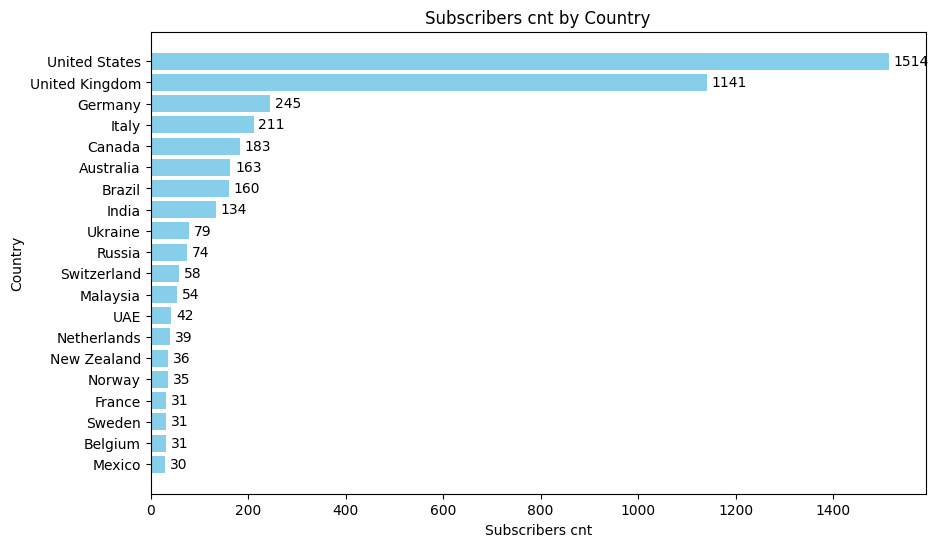

In [48]:
top_country_by_subscribes = (df.groupby("country")["subscribers"].sum().sort_values(ascending=True).tail(20))
plt.figure(figsize=(10, 6))
bars = plt.barh(top_country_by_subscribes.index, top_country_by_subscribes.values, color="skyblue")
plt.title("Subscribers cnt by Country")
plt.xlabel("Subscribers cnt")
plt.ylabel("Country")

for bar in bars:
    plt.text(
        bar.get_width() + 10,  # трохи правіше від кінця бару
        bar.get_y() + bar.get_height() / 2,
        f"{int(bar.get_width())}",  # округлюємо значення
        va="center",
        fontsize=10,
        color="black"
    )

plt.show()

Тут ми визначили 20 найпопулярніших країн, надалі будемо проводити аналіз над над ними. Бачимо що United States та United Kingdom переважають з великим відривом.

##Оплачуваний трафік

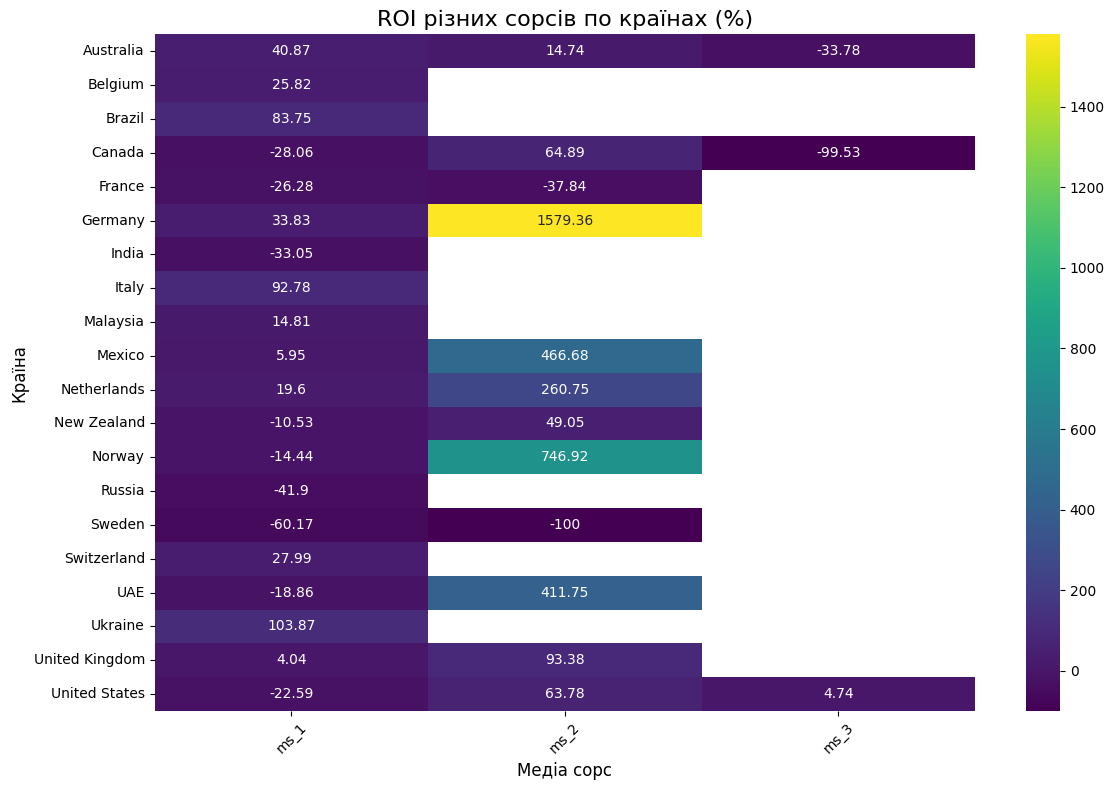

In [49]:

df_paid = df[(df["country"].isin(top_country_by_subscribes.index)) &(df["spend_usd"] > 0) &(df["case_type"]=="Paid with subs")]

pivot_roi = (df_paid.groupby(["country", "media_source"]).agg(
        spend_usd=("spend_usd", "sum"),
        revenue=("erevenue_12month_usd", "sum"),
        subscribers=("subscribers", "sum")
        )
    .reset_index()
)

pivot_roi["roi"] = round((pivot_roi["revenue"] - pivot_roi["spend_usd"]) / pivot_roi["spend_usd"] * 100, 2)


pivot_table = pivot_roi.pivot(
    index="country",
    columns="media_source",
    values="roi"
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt='g',
    cmap='viridis'
)

plt.title("ROI різних сорсів по країнах (%)", fontsize=16)
plt.ylabel("Країна", fontsize=12)
plt.xlabel("Медіа сорс", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

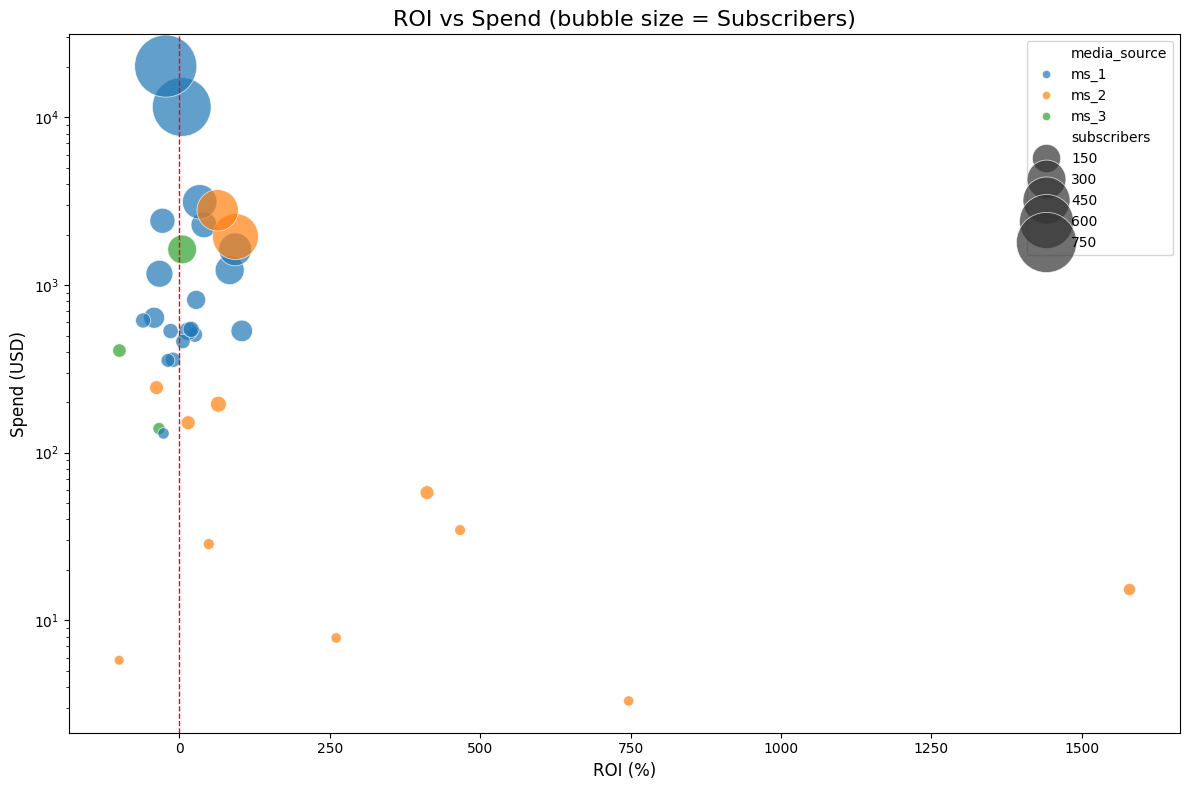

In [50]:

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=pivot_roi,
    x="roi",
    y="spend_usd",
    size="subscribers",
    hue="media_source",
    sizes=(50, 2000),
    alpha=0.7
)

plt.title("ROI vs Spend (bubble size = Subscribers)", fontsize=16)
plt.xlabel("ROI (%)", fontsize=12)
plt.ylabel("Spend (USD)", fontsize=12)
plt.axvline(0, color="red", linestyle="--", linewidth=1)
plt.yscale("log")
plt.tight_layout()
plt.show()

На основі цих двох візуалізацій можна робити висновки. Бачимо ситуацію - високий ROI при низькому рівні spend та subscribers не є показником успішної кампанії, оскільки метрика нестабільна. Додатково переглянувши датасет в Google Sheets, я знайшла значення яке може спотворювати ці дані - маленькі вкладення принесли відносно більше підписок. Через малий обсяг даних для країни Німеччини в ms2 такий результат не буде мати статистичної надійності. З Норвегією, Мехіко та UAE ситуація та сама - даних замало, щоб спиратись що кампанія sm2 буде приносити там великий дохід. В висновку проведемо додатковий аналіз для сорсів ms2 та ms3 трохи нижче, виділивши країни, де вкладення в них були найбільші.

###Аналіз ms1 по країнах
Бачимо досить багато від'ємних значень, і, можемо сказати що закупляти когорти для ms1 в таких країнах як США, UAE, Швеція, росія, Франція, Канада, Індія, Нова Зеландія, Норвегія є невигідним. Тим часом як для таких країн як Україна, Швейцарія, Італія, Бразилія, Бельгія, Австралія вкладення приносять високий відсоток чистого доходу, що дозволяє зробити висновки щодо посилення закупівлі когорт для цих країн в даному сорсі

###Аналіз ms2 по країнах

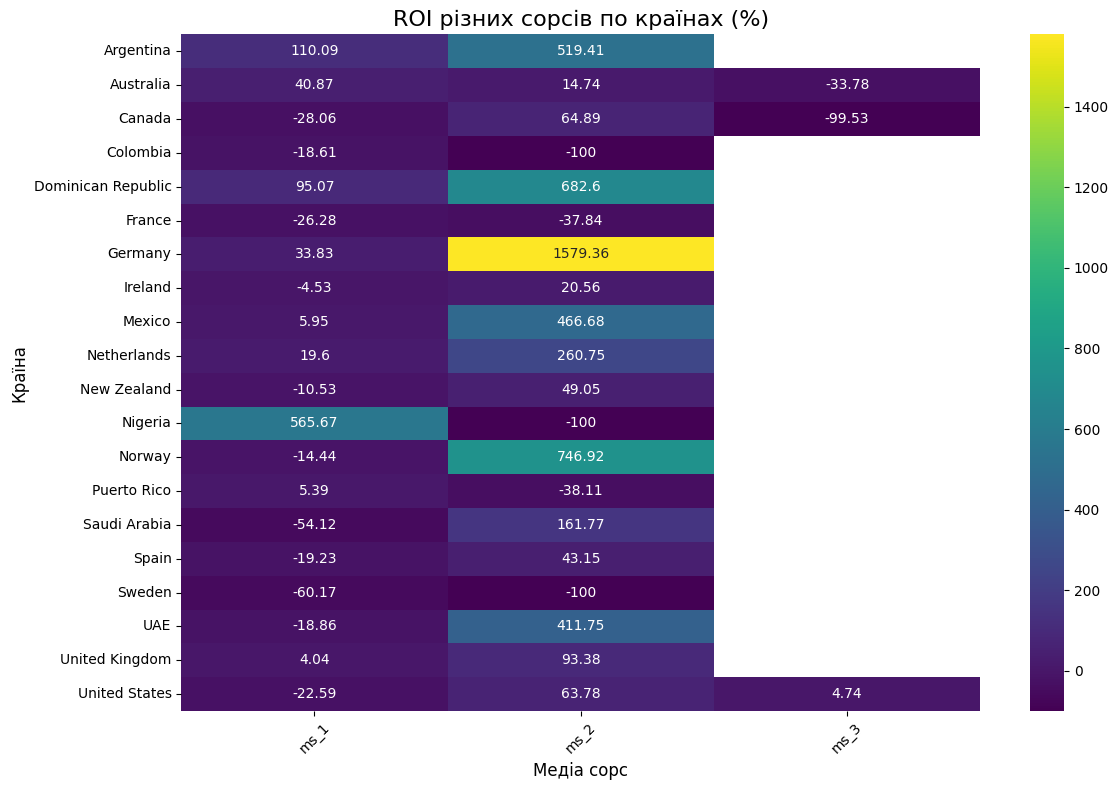

In [51]:
#робимо дял списку країн з найбльшими витратами для ms2
top_country_by_spend_ms2 = (
    df[df["media_source"]=="ms_2"]
    .groupby("country")["spend_usd"].sum()
    .sort_values(ascending=True)
    .tail(20)
)
df_paid = df[(df["country"].isin(top_country_by_spend_ms2.index)) &(df["case_type"]=="Paid with subs")]

pivot_roi = (df_paid.groupby(["country", "media_source"]).agg(
        spend_usd=("spend_usd", "sum"),
        revenue=("erevenue_12month_usd", "sum"),
        subscribers=("subscribers", "sum")
        )
    .reset_index()
)

pivot_roi["roi"] = round((pivot_roi["revenue"] - pivot_roi["spend_usd"]) / pivot_roi["spend_usd"] * 100, 2)


pivot_table = pivot_roi.pivot(
    index="country",
    columns="media_source",
    values="roi"
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt='g',
    cmap='viridis'
)

plt.title("ROI різних сорсів по країнах (%)", fontsize=16)
plt.ylabel("Країна", fontsize=12)
plt.xlabel("Медіа сорс", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Знову ж таки - на великі значення ROI спиратись не буду, оскільки датасет містить замало інформації для оплачуваного трафіку в ms2. Компанії в даному випадку найбвльш вигідно закуповувати когорти для другого сорсу в таких країнах як Австралія, США, Велика Британія, Іспанія, Нова Зеландія, Ірландія, Канада. Не варто вкладатись в такі країни як Пуерто Ріко, Швеція, Нігерія, Франція.

###Аналіз ms3 по країнах

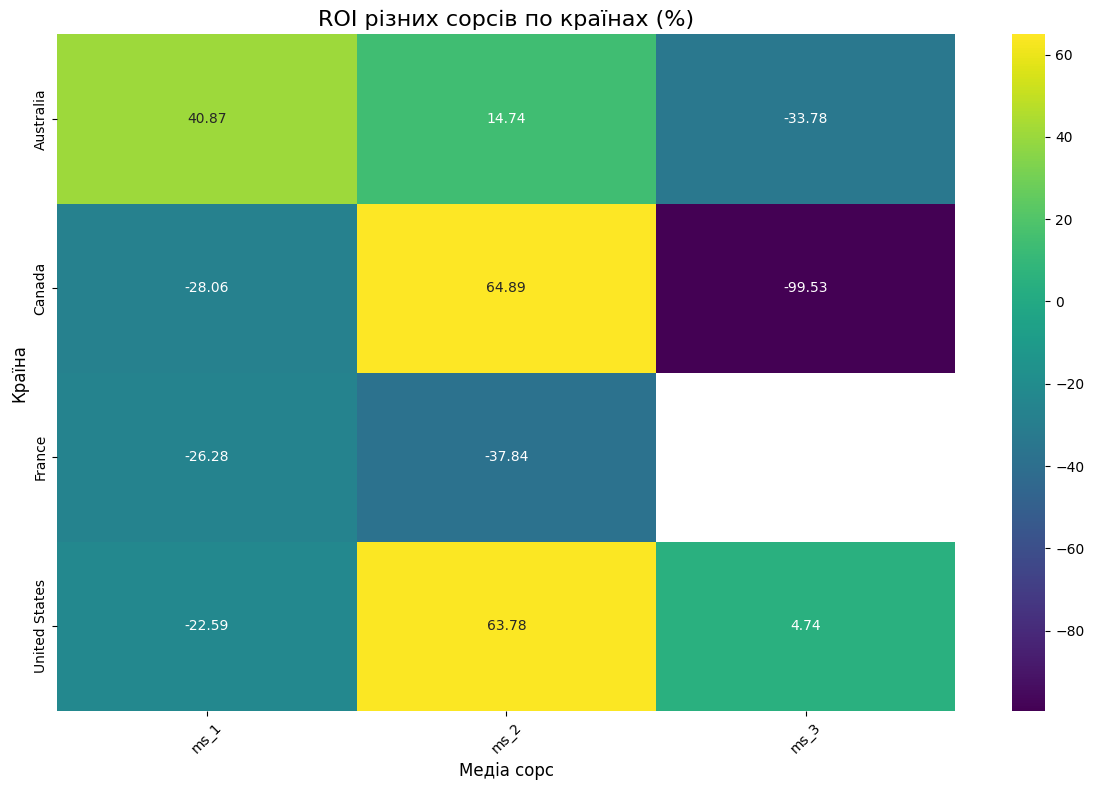

In [52]:
#робимо для списку країн з найбільшими витратами для ms3
top_country_by_spend_ms3 = (
    df[df["media_source"]=="ms_3"]
    .groupby("country")["spend_usd"].sum()
    .sort_values(ascending=True)
    .tail(20)
)
df_paid = df[(df["country"].isin(top_country_by_spend_ms3.index)) &(df["case_type"]=="Paid with subs")]

pivot_roi = (df_paid.groupby(["country", "media_source"]).agg(
        spend_usd=("spend_usd", "sum"),
        revenue=("erevenue_12month_usd", "sum"),
        subscribers=("subscribers", "sum")
        )
    .reset_index()
)

pivot_roi["roi"] = round((pivot_roi["revenue"] - pivot_roi["spend_usd"]) / pivot_roi["spend_usd"] * 100, 2)


pivot_table = pivot_roi.pivot(
    index="country",
    columns="media_source",
    values="roi"
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt='g',
    cmap='viridis'
)

plt.title("ROI різних сорсів по країнах (%)", fontsize=16)
plt.ylabel("Країна", fontsize=12)
plt.xlabel("Медіа сорс", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Тут цікава ситуація. В датасеті всього лише 9 рядків з оплачуваним трафіком для ms_3, все інше підписки без вкладень. Тобто приблизно по три рядки на кожну країну, що не дає нам зробити значущих висновків.

##Неоплачуваний трафік

Тут найкраще проводити аналіз за ARPU, в розрізі країн з найбільшою к-стю підписок та сорсів.

In [53]:
top_country_by_subscribes_organic_ms1 = (
    df[(df['channel type'] == "Organic") & (df['media_source'] == "ms_1")]
    .groupby("country")["subscribers"]
    .sum()
    .sort_values(ascending=True)
    .tail(20)
)

top_country_by_subscribes_organic_ms1

,subscribers
country,


В датасеті для ms1 є дані лише про оплачуваний трафік.

In [55]:
top_country_by_subscribes_organic_ms2 = (
    df[(df['channel type'] == "Organic") & (df['media_source'] == "ms_2")]
    .groupby("country")["subscribers"]
    .sum()
    .sort_values(ascending=True)
    .tail(20)
)

top_country_by_subscribes_organic_ms2

,subscribers
country,
Denmark,1
France,1
Poland,1
Italy,1
Sweden,1
Slovenia,1
Norway,2
Austria,2
Qatar,2


Тут дані є, але їх замало для аналізу

In [56]:
top_country_by_subscribes_organic_ms3 = (
    df[(df['channel type'] == "Organic") & (df['media_source'] == "ms_3")]
    .groupby("country")["subscribers"]
    .sum()
    .sort_values(ascending=True)
    .tail(20)
)

top_country_by_subscribes_organic_ms3

,subscribers
country,
France,1
Australia,8
Canada,16
United States,214


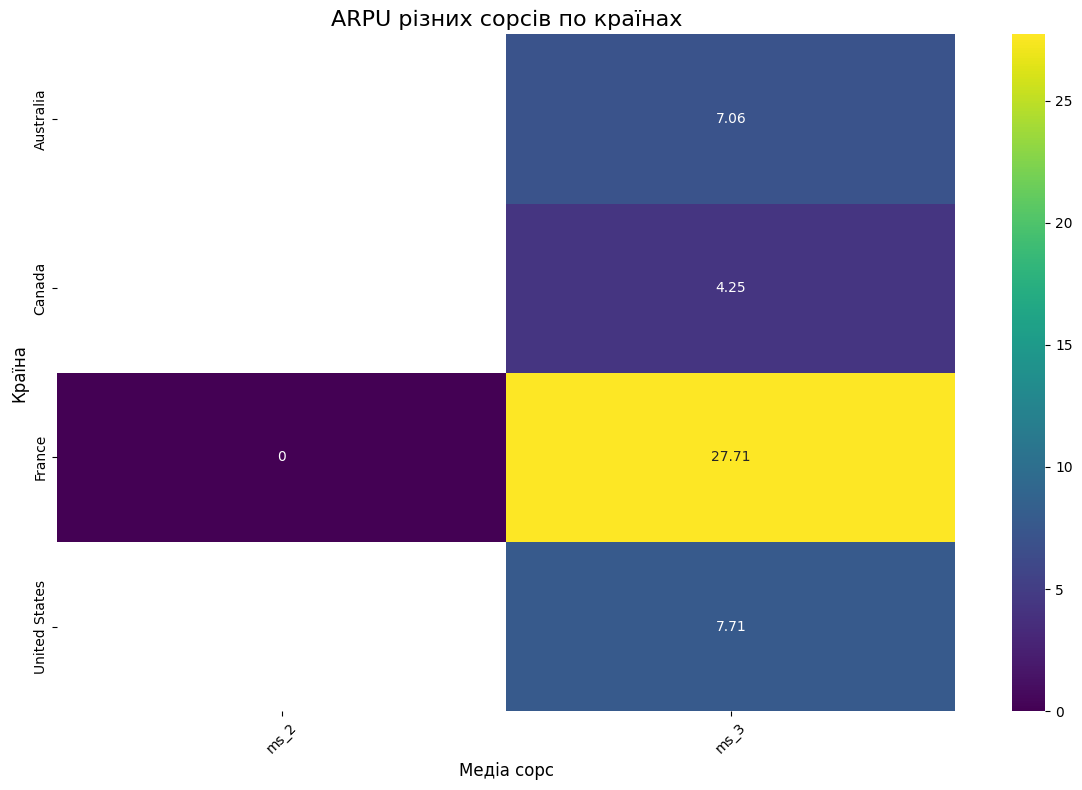

In [62]:
df_organic = df[(df["country"].isin(top_country_by_subscribes_organic_ms3.index)) &(df['channel type'] == "Organic")]

pivot_ARPU = (df_organic.groupby(["country", "media_source"]).agg(
        revenue=("erevenue_12month_usd", "sum"),
        subscribers=("subscribers", "sum")
        )
    .reset_index()
)

pivot_ARPU["ARPU"] = round(pivot_ARPU["revenue"]/pivot_ARPU["subscribers"], 2)


pivot_ARP_table = pivot_ARPU.pivot(
    index="country",
    columns="media_source",
    values="ARPU"
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_ARP_table,
    annot=True,
    fmt='g',
    cmap='viridis'
)

plt.title("ARPU різних сорсів по країнах", fontsize=16)
plt.ylabel("Країна", fontsize=12)
plt.xlabel("Медіа сорс", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Тут можна зробити висновки саме до США по ms3, оскільки даних достатньо. Ми бачимо, що кожен юзер при приносить нам 7.71 usd чистого прибутку, з чого можемо зробити припущення, що закупівля когорт в даній країні може принести досить великий прибуток.

##CPU

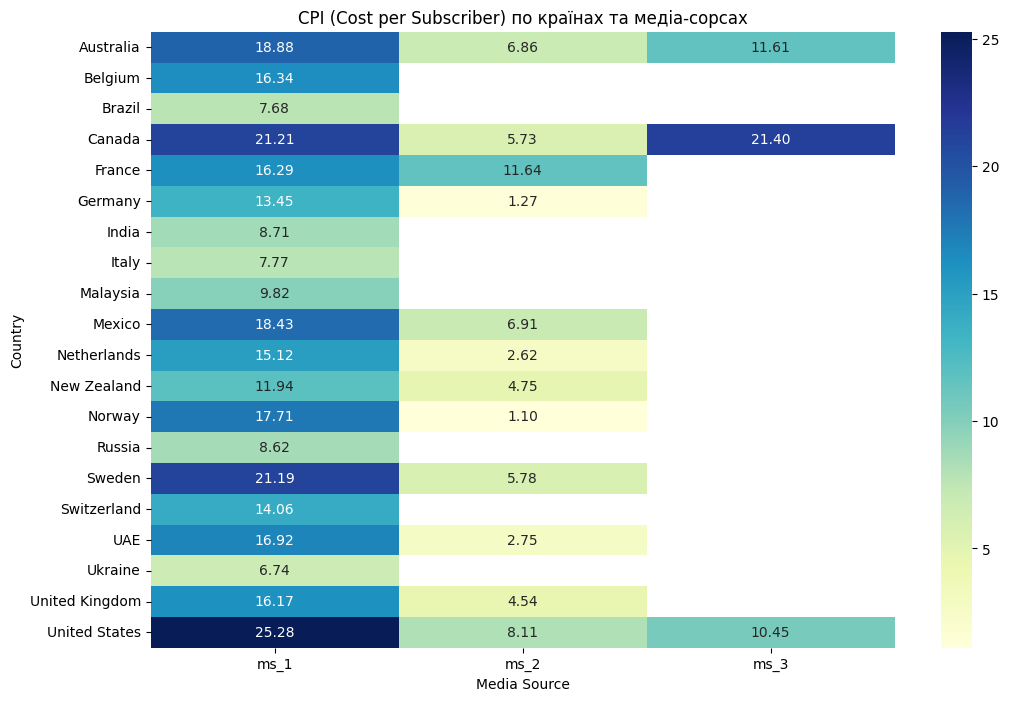

In [68]:
cpu_data_ms1 = df[(df["country"].isin(top_country_by_subscribes.index))&(df["spend_usd"] > 0) & (df["case_type"]=="Paid with subs")].groupby(
    ["country", "media_source"]
).agg(
    spend_usd=("spend_usd", "sum"),
    subscribers=("subscribers", "sum")
).reset_index()

cpu_data_ms1["cpi"] = cpu_data_ms1["spend_usd"] / cpu_data_ms1["subscribers"]

cpi_pivot = cpu_data_ms1.pivot(index="country", columns="media_source", values="cpi")

plt.figure(figsize=(12,8))
sns.heatmap(cpi_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("CPU по країнах та медіа-сорсах")
plt.xlabel("Media Source")
plt.ylabel("Country")
plt.show()

Для першого медіа сорсу "найдешевшими" є підписники в таких країнах як Бразилія, Італія, Малайзія, Україна, Індія. Дорожчими - США, Британія, Швеція, Канада, Австралія, Бельгія.

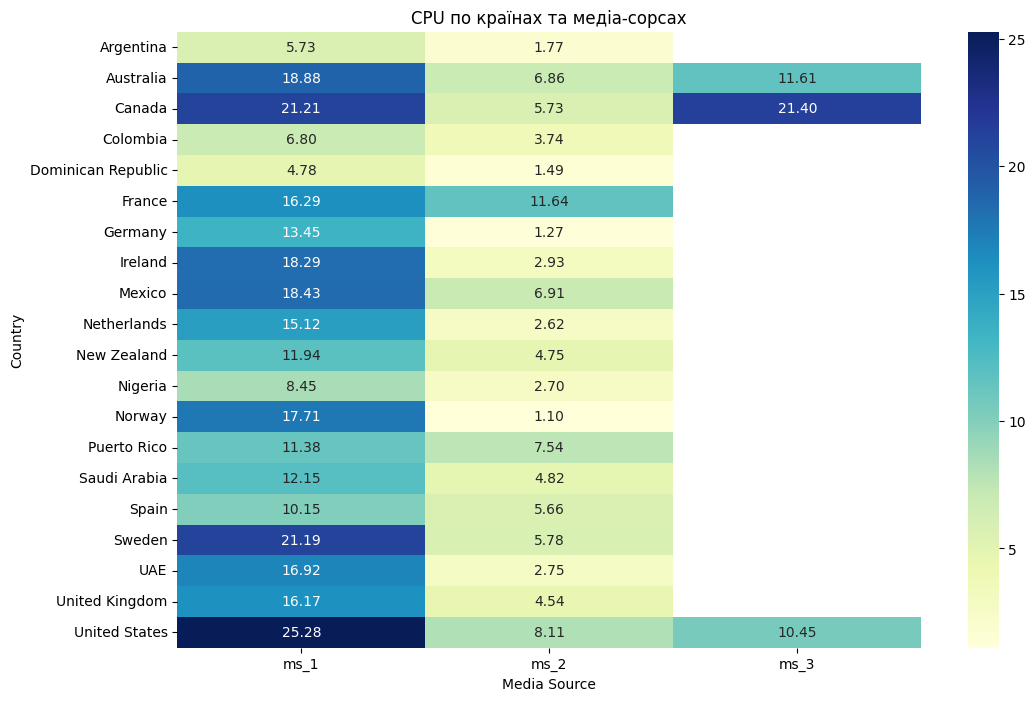

In [70]:
cpu_data_ms2 = df[(df["country"].isin(top_country_by_spend_ms2.index))&(df["spend_usd"] > 0) & (df["case_type"]=="Paid with subs")].groupby(
    ["country", "media_source"]
).agg(
    spend_usd=("spend_usd", "sum"),
    subscribers=("subscribers", "sum")
).reset_index()

cpu_data_ms2["cpi"] = cpu_data_ms2["spend_usd"] / cpu_data_ms2["subscribers"]

cpi_pivot = cpu_data_ms2.pivot(index="country", columns="media_source", values="cpi")

plt.figure(figsize=(12,8))
sns.heatmap(cpi_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("CPU по країнах та медіа-сорсах")
plt.xlabel("Media Source")
plt.ylabel("Country")
plt.show()

Для другого медіа сорсу "найдешевшими" є підписники в таких країнах як Британія, Швеція, Іспанія, Колумбія, Канада. Дорожчими - США, Франція, Мехіко,Австралія,.

Для третього сорсу нема потреби в аналізі CPU, оскільки тут дані по оплачуваному трафіку майже відсутні.

##ARPU

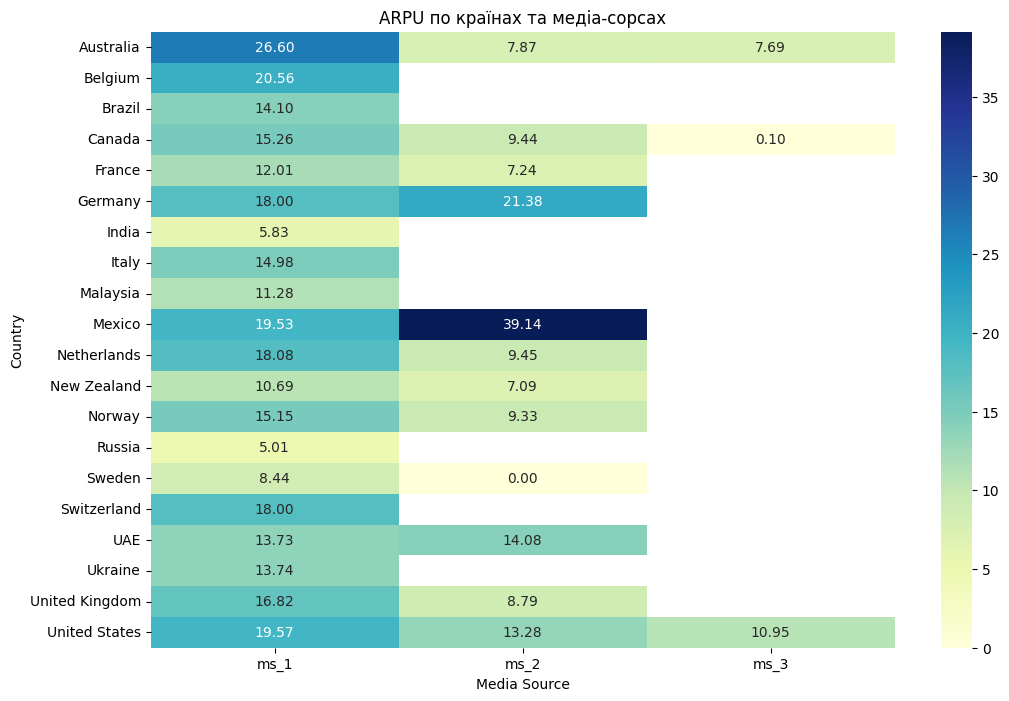

In [73]:
arpu_data = df[(df["country"].isin(top_country_by_subscribes.index))&(df["spend_usd"] > 0) & (df["case_type"]=="Paid with subs")].groupby(
    ["country", "media_source"]
).agg(
    revenue=("erevenue_12month_usd", "sum"),
    subscribers=("subscribers", "sum")
).reset_index()

arpu_data["arpu"] = arpu_data["revenue"] / arpu_data["subscribers"]

arpu_pivot = arpu_data.pivot(index="country", columns="media_source", values="arpu")

plt.figure(figsize=(12,8))
sns.heatmap(arpu_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("ARPU по країнах та медіа-сорсах")
plt.xlabel("Media Source")
plt.ylabel("Country")
plt.show()

Для першого медіа сорсу найбільший прибуток приносить користувач в Австралії, Бельгії, Мексиці, США, Швейцарії, Британії, Німеччині, Канаді, Бразилії, Україні, UAE. Найменший - росія, Швеція, Індія.

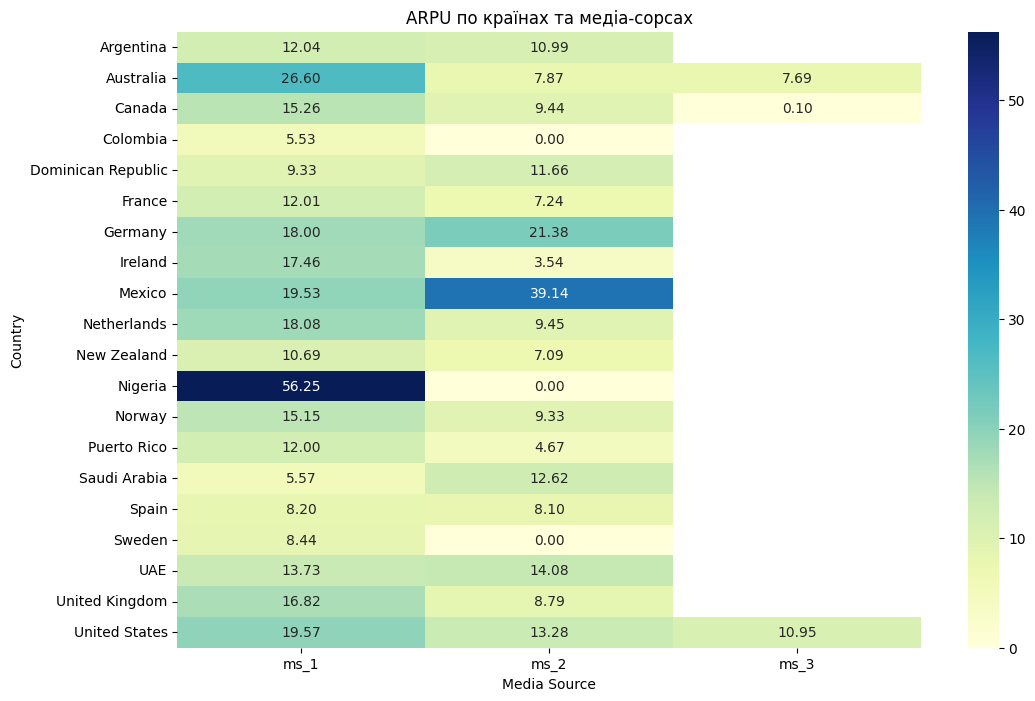

In [74]:
arpu_data = df[(df["country"].isin(top_country_by_spend_ms2.index))&(df["spend_usd"] > 0) & (df["case_type"]=="Paid with subs")].groupby(
    ["country", "media_source"]
).agg(
    revenue=("erevenue_12month_usd", "sum"),
    subscribers=("subscribers", "sum")
).reset_index()

arpu_data["arpu"] = arpu_data["revenue"] / arpu_data["subscribers"]

arpu_pivot = arpu_data.pivot(index="country", columns="media_source", values="arpu")

plt.figure(figsize=(12,8))
sns.heatmap(arpu_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("ARPU по країнах та медіа-сорсах")
plt.xlabel("Media Source")
plt.ylabel("Country")
plt.show()

Для другого медіа сорсу найбільший прибуток приносить користувач в США, UAE, Саудівській Аравії, Домініканська республіка, Аргентина. Найменший - Австралія, Канада, Пуерто-Ріко, Британія.

#Висновки

Аналіз даних показав, що серед 20 найпопулярніших країн лідерами за кількістю підписок є Сполучені Штати та Велика Британія. Щодо оплачуваного трафіку - високий ROI при невеликих витратах і малій кількості підписок не обов’язково свідчить про успішність кампанії, оскільки такі метрики нестабільні. Наприклад, для Німеччини, Норвегії, Мехіко та ОАЕ даних замало, щоб робити надійні висновки про ефективність сорсів ms2 та ms3. Тому подальший аналіз слід робити, виділяючи країни, де вкладення були найбільші, особливо для ms2 та ms3.

Для першого медіа-сорсу ms1 є досить багато від’ємних значень ROI, що показує на невигідність закупівлі когорти в таких країнах, як США, UAE, Швеція, Росія, Франція, Канада, Індія, Нова Зеландія та Норвегія. Водночас для України, Швейцарії, Італії, Бразилії, Бельгії та Австралії витрати приносять досить високий відсоток чистого доходу, що дозволяє зробити пропозицію на посилення закупівель когорт у цих країнах для першого сорсу. Найдешевшими підписниками для ms1 є користувачі з Бразилії, Італії, Малайзії, України та Індії, тоді як найдорожчі підписники знаходяться в США, Британії, Швеції, Канаді, Австралії та Бельгії. Найбільший прибуток на користувача приносить аудиторія з Австралії, Бельгії, Мексики, США, Швейцарії, Британії, Німеччини, Канади, Бразилії, України та UAE, а найменший — з Росії, Швеції та Індії. Можна помітити закономірність, що більші вкладення в перший сорс для Британії, США, Австралії приносить в результаті і більший прибуток. Тоді як в Швеції досить дороги підписники приносять менший прибуток, тому вкладення туди варто зменшити.

Для другого медіа-сорсу ms2 дані про оплачуваний трафік обмежені, тому високі ROI не є надійними. Відкидаючи такі "аномалії", визначено, що компанії найбільш вигідно закуповувати когорти для ms2 в таких країнах, як Австралія, США, Велика Британія, Іспанія, Нова Зеландія, Ірландія та Канада. Не варто вкладати кошти в Пуерто-Ріко, Швецію, Нігерію та Францію. Найдешевшими підписниками для ms2 є користувачі з Британії, Швеції, Іспанії, Колумбії та Канади, а найдорожчі — з США, Франції, Мексики та Австралії. За ARPU найбільший прибуток приносить аудиторія з США, UAE, Саудівської Аравії, Домініканської Республіки та Аргентини, а найменший — з Австралії, Канади, Пуерто-Ріко та Великої Британії.

Для третього медіа-сорсу ms3 кількість рядків з оплачуваним трафіком дуже мала. Та говорячи про органічний трафік - в США ARPU складає 7.71 USD, що дозволяє припустити, що закупівля когорт у цій країні може приносити відчутний прибуток.

Щодо неоплачуваного трафіку, найбільш доцільно аналізувати ARPU тільки в розрізі ms3. Для ms1 дані є лише про оплачуваний трафік, для ms2 вони є, але недостатні для статистично значущих висновків, тоді як для ms3 в США дані дозволяють робити припущення про прибутковість закупівлі.